In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer
from uncertainty_testbed.uncertainty_models.hla_dropout import HLADropout, HLALinear

2022-06-22 11:42:10.057711: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 11:42:10.057733: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        layers = (
            keras.Input(shape=(eg.num_inputs,), name="input"),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(60, activation="relu"),
            keras.layers.Dropout(0.25),
            HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
                      activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
        model = HLADropout(
            layer_tuple=layers,
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=("accuracy", "AUC"),
            name="HLADropout"
        )

        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_hla_linear_loss"]
        val_auc = history_dict["val_hla_linear_auc"]
        val_accuracy = history_dict["val_hla_linear_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            #champion_params["model"] = keras.models.clone_model(model)
        del model
        gc;
        

#model = keras.models.clone_model(champion_params["model"])

2022-06-22 11:42:15.905213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-22 11:42:15.905242: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-22 11:42:15.905262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-06-22 11:42:15.906307: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/119
130/130 [==============================] - 2s 6ms/step - loss: 0.6961 - hla_linear_loss: 0.6961 - hla_linear_accuracy: 0.5168 - hla_linear_auc: 0.5258 - val_loss: 0.6864 - val_hla_linear_loss: 0.6864 - val_hla_linear_accuracy: 0.5567 - val_hla_linear_auc: 0.5769
Epoch 2/119
130/130 [==============================] - 0s 4ms/step - loss: 0.6943 - hla_linear_loss: 0.6943 - hla_linear_accuracy: 0.5227 - hla_linear_auc: 0.5320 - val_loss: 0.6831 - val_hla_linear_loss: 0.6831 - val_hla_linear_accuracy: 0.5788 - val_hla_linear_auc: 0.6036
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6901 - hla_linear_loss: 0.6901 - hla_linear_accuracy: 0.5374 - hla_linear_auc: 0.5502 - val_loss: 0.6799 - val_hla_linear_loss: 0.6799 - val_hla_linear_accuracy: 0.5968 - val_hla_linear_auc: 0.6277
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6887 - hla_linear_loss: 0.6887 - hla_linear_accuracy: 0.5374 - hla_linear_auc: 0.5549 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 4ms/step - loss: 0.5307 - hla_linear_loss: 0.5307 - hla_linear_accuracy: 0.7360 - hla_linear_auc: 0.8180 - val_loss: 0.4435 - val_hla_linear_loss: 0.4435 - val_hla_linear_accuracy: 0.8487 - val_hla_linear_auc: 0.9181
Epoch 32/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5248 - hla_linear_loss: 0.5248 - hla_linear_accuracy: 0.7394 - hla_linear_auc: 0.8216 - val_loss: 0.4355 - val_hla_linear_loss: 0.4355 - val_hla_linear_accuracy: 0.8519 - val_hla_linear_auc: 0.9207
Epoch 33/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5214 - hla_linear_loss: 0.5214 - hla_linear_accuracy: 0.7427 - hla_linear_auc: 0.8243 - val_loss: 0.4281 - val_hla_linear_loss: 0.4281 - val_hla_linear_accuracy: 0.8548 - val_hla_linear_auc: 0.9228
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.5154 - hla_linear_loss: 0.5154 - hla_linear_accuracy: 0.7488 - hla_linear_auc: 0.8293 - val_lo

Epoch 61/119
130/130 [==============================] - 1s 4ms/step - loss: 0.4436 - hla_linear_loss: 0.4436 - hla_linear_accuracy: 0.8057 - hla_linear_auc: 0.8825 - val_loss: 0.3405 - val_hla_linear_loss: 0.3405 - val_hla_linear_accuracy: 0.8952 - val_hla_linear_auc: 0.9424
Epoch 62/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4336 - hla_linear_loss: 0.4336 - hla_linear_accuracy: 0.8123 - hla_linear_auc: 0.8883 - val_loss: 0.3393 - val_hla_linear_loss: 0.3393 - val_hla_linear_accuracy: 0.8957 - val_hla_linear_auc: 0.9426
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4366 - hla_linear_loss: 0.4366 - hla_linear_accuracy: 0.8111 - hla_linear_auc: 0.8869 - val_loss: 0.3382 - val_hla_linear_loss: 0.3382 - val_hla_linear_accuracy: 0.8963 - val_hla_linear_auc: 0.9428
Epoch 64/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4310 - hla_linear_loss: 0.4310 - hla_linear_accuracy: 0.8146 - hla_linear_auc: 0.8906 - val_lo

Epoch 91/119
130/130 [==============================] - 1s 4ms/step - loss: 0.3991 - hla_linear_loss: 0.3991 - hla_linear_accuracy: 0.8389 - hla_linear_auc: 0.9084 - val_loss: 0.3150 - val_hla_linear_loss: 0.3150 - val_hla_linear_accuracy: 0.9048 - val_hla_linear_auc: 0.9473
Epoch 92/119
130/130 [==============================] - 1s 4ms/step - loss: 0.3975 - hla_linear_loss: 0.3975 - hla_linear_accuracy: 0.8377 - hla_linear_auc: 0.9086 - val_loss: 0.3142 - val_hla_linear_loss: 0.3142 - val_hla_linear_accuracy: 0.9057 - val_hla_linear_auc: 0.9474
Epoch 93/119
130/130 [==============================] - 1s 4ms/step - loss: 0.3935 - hla_linear_loss: 0.3935 - hla_linear_accuracy: 0.8396 - hla_linear_auc: 0.9110 - val_loss: 0.3135 - val_hla_linear_loss: 0.3135 - val_hla_linear_accuracy: 0.9062 - val_hla_linear_auc: 0.9476
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3951 - hla_linear_loss: 0.3951 - hla_linear_accuracy: 0.8408 - hla_linear_auc: 0.9105 - val_lo

Epoch 1/119
130/130 [==============================] - 2s 5ms/step - loss: 0.6916 - hla_linear_loss: 0.6916 - hla_linear_accuracy: 0.5277 - hla_linear_auc: 0.5392 - val_loss: 0.6792 - val_hla_linear_loss: 0.6792 - val_hla_linear_accuracy: 0.6007 - val_hla_linear_auc: 0.6460
Epoch 2/119
130/130 [==============================] - 0s 4ms/step - loss: 0.6838 - hla_linear_loss: 0.6838 - hla_linear_accuracy: 0.5524 - hla_linear_auc: 0.5759 - val_loss: 0.6703 - val_hla_linear_loss: 0.6703 - val_hla_linear_accuracy: 0.6425 - val_hla_linear_auc: 0.7054
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6778 - hla_linear_loss: 0.6778 - hla_linear_accuracy: 0.5711 - hla_linear_auc: 0.5993 - val_loss: 0.6608 - val_hla_linear_loss: 0.6608 - val_hla_linear_accuracy: 0.6703 - val_hla_linear_auc: 0.7461
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6717 - hla_linear_loss: 0.6717 - hla_linear_accuracy: 0.5844 - hla_linear_auc: 0.6222 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4632 - hla_linear_loss: 0.4632 - hla_linear_accuracy: 0.7894 - hla_linear_auc: 0.8694 - val_loss: 0.3634 - val_hla_linear_loss: 0.3634 - val_hla_linear_accuracy: 0.8856 - val_hla_linear_auc: 0.9384
Epoch 32/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4556 - hla_linear_loss: 0.4556 - hla_linear_accuracy: 0.7957 - hla_linear_auc: 0.8750 - val_loss: 0.3602 - val_hla_linear_loss: 0.3602 - val_hla_linear_accuracy: 0.8866 - val_hla_linear_auc: 0.9389
Epoch 33/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4515 - hla_linear_loss: 0.4515 - hla_linear_accuracy: 0.7969 - hla_linear_auc: 0.8770 - val_loss: 0.3571 - val_hla_linear_loss: 0.3571 - val_hla_linear_accuracy: 0.8885 - val_hla_linear_auc: 0.9394
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4494 - hla_linear_loss: 0.4494 - hla_linear_accuracy: 0.8005 - hla_linear_auc: 0.8794 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3979 - hla_linear_loss: 0.3979 - hla_linear_accuracy: 0.8410 - hla_linear_auc: 0.9094 - val_loss: 0.3190 - val_hla_linear_loss: 0.3190 - val_hla_linear_accuracy: 0.9028 - val_hla_linear_auc: 0.9460
Epoch 62/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4029 - hla_linear_loss: 0.4029 - hla_linear_accuracy: 0.8381 - hla_linear_auc: 0.9073 - val_loss: 0.3182 - val_hla_linear_loss: 0.3182 - val_hla_linear_accuracy: 0.9036 - val_hla_linear_auc: 0.9461
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4021 - hla_linear_loss: 0.4021 - hla_linear_accuracy: 0.8370 - hla_linear_auc: 0.9077 - val_loss: 0.3176 - val_hla_linear_loss: 0.3176 - val_hla_linear_accuracy: 0.9036 - val_hla_linear_auc: 0.9462
Epoch 64/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4007 - hla_linear_loss: 0.4007 - hla_linear_accuracy: 0.8402 - hla_linear_auc: 0.9088 - val_lo

Epoch 91/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3638 - hla_linear_loss: 0.3638 - hla_linear_accuracy: 0.8640 - hla_linear_auc: 0.9258 - val_loss: 0.2989 - val_hla_linear_loss: 0.2989 - val_hla_linear_accuracy: 0.9117 - val_hla_linear_auc: 0.9498
Epoch 92/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3674 - hla_linear_loss: 0.3674 - hla_linear_accuracy: 0.8605 - hla_linear_auc: 0.9236 - val_loss: 0.2982 - val_hla_linear_loss: 0.2982 - val_hla_linear_accuracy: 0.9122 - val_hla_linear_auc: 0.9499
Epoch 93/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3655 - hla_linear_loss: 0.3655 - hla_linear_accuracy: 0.8638 - hla_linear_auc: 0.9248 - val_loss: 0.2977 - val_hla_linear_loss: 0.2977 - val_hla_linear_accuracy: 0.9126 - val_hla_linear_auc: 0.9500
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3636 - hla_linear_loss: 0.3636 - hla_linear_accuracy: 0.8620 - hla_linear_auc: 0.9249 - val_lo

Epoch 1/119
130/130 [==============================] - 2s 5ms/step - loss: 0.6954 - hla_linear_loss: 0.6954 - hla_linear_accuracy: 0.5198 - hla_linear_auc: 0.5297 - val_loss: 0.6795 - val_hla_linear_loss: 0.6795 - val_hla_linear_accuracy: 0.5767 - val_hla_linear_auc: 0.6168
Epoch 2/119
130/130 [==============================] - 0s 4ms/step - loss: 0.6867 - hla_linear_loss: 0.6867 - hla_linear_accuracy: 0.5401 - hla_linear_auc: 0.5609 - val_loss: 0.6702 - val_hla_linear_loss: 0.6702 - val_hla_linear_accuracy: 0.6143 - val_hla_linear_auc: 0.6652
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6796 - hla_linear_loss: 0.6796 - hla_linear_accuracy: 0.5614 - hla_linear_auc: 0.5879 - val_loss: 0.6607 - val_hla_linear_loss: 0.6607 - val_hla_linear_accuracy: 0.6396 - val_hla_linear_auc: 0.7003
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6733 - hla_linear_loss: 0.6733 - hla_linear_accuracy: 0.5760 - hla_linear_auc: 0.6107 - val_loss: 

Epoch 31/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4440 - hla_linear_loss: 0.4440 - hla_linear_accuracy: 0.8052 - hla_linear_auc: 0.8827 - val_loss: 0.3500 - val_hla_linear_loss: 0.3500 - val_hla_linear_accuracy: 0.8868 - val_hla_linear_auc: 0.9395
Epoch 32/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4442 - hla_linear_loss: 0.4442 - hla_linear_accuracy: 0.8038 - hla_linear_auc: 0.8823 - val_loss: 0.3472 - val_hla_linear_loss: 0.3472 - val_hla_linear_accuracy: 0.8891 - val_hla_linear_auc: 0.9403
Epoch 33/119
130/130 [==============================] - 0s 4ms/step - loss: 0.4409 - hla_linear_loss: 0.4409 - hla_linear_accuracy: 0.8057 - hla_linear_auc: 0.8843 - val_loss: 0.3448 - val_hla_linear_loss: 0.3448 - val_hla_linear_accuracy: 0.8907 - val_hla_linear_auc: 0.9409
Epoch 34/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4344 - hla_linear_loss: 0.4344 - hla_linear_accuracy: 0.8100 - hla_linear_auc: 0.8877 - val_lo

Epoch 61/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3856 - hla_linear_loss: 0.3856 - hla_linear_accuracy: 0.8509 - hla_linear_auc: 0.9159 - val_loss: 0.3086 - val_hla_linear_loss: 0.3086 - val_hla_linear_accuracy: 0.9109 - val_hla_linear_auc: 0.9484
Epoch 62/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3858 - hla_linear_loss: 0.3858 - hla_linear_accuracy: 0.8482 - hla_linear_auc: 0.9149 - val_loss: 0.3077 - val_hla_linear_loss: 0.3077 - val_hla_linear_accuracy: 0.9104 - val_hla_linear_auc: 0.9487
Epoch 63/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3809 - hla_linear_loss: 0.3809 - hla_linear_accuracy: 0.8501 - hla_linear_auc: 0.9177 - val_loss: 0.3068 - val_hla_linear_loss: 0.3068 - val_hla_linear_accuracy: 0.9105 - val_hla_linear_auc: 0.9488
Epoch 64/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3816 - hla_linear_loss: 0.3816 - hla_linear_accuracy: 0.8542 - hla_linear_auc: 0.9173 - val_lo

Epoch 91/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3467 - hla_linear_loss: 0.3467 - hla_linear_accuracy: 0.8731 - hla_linear_auc: 0.9319 - val_loss: 0.2861 - val_hla_linear_loss: 0.2861 - val_hla_linear_accuracy: 0.9172 - val_hla_linear_auc: 0.9530
Epoch 92/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3491 - hla_linear_loss: 0.3491 - hla_linear_accuracy: 0.8706 - hla_linear_auc: 0.9303 - val_loss: 0.2854 - val_hla_linear_loss: 0.2854 - val_hla_linear_accuracy: 0.9169 - val_hla_linear_auc: 0.9531
Epoch 93/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3463 - hla_linear_loss: 0.3463 - hla_linear_accuracy: 0.8698 - hla_linear_auc: 0.9320 - val_loss: 0.2846 - val_hla_linear_loss: 0.2846 - val_hla_linear_accuracy: 0.9172 - val_hla_linear_auc: 0.9533
Epoch 94/119
130/130 [==============================] - 0s 3ms/step - loss: 0.3427 - hla_linear_loss: 0.3427 - hla_linear_accuracy: 0.8737 - hla_linear_auc: 0.9335 - val_lo

Epoch 1/249
130/130 [==============================] - 1s 5ms/step - loss: 0.7086 - hla_linear_loss: 0.7086 - hla_linear_accuracy: 0.4935 - hla_linear_auc: 0.4923 - val_loss: 0.7024 - val_hla_linear_loss: 0.7024 - val_hla_linear_accuracy: 0.4704 - val_hla_linear_auc: 0.4678
Epoch 2/249
130/130 [==============================] - 0s 3ms/step - loss: 0.7065 - hla_linear_loss: 0.7065 - hla_linear_accuracy: 0.4954 - hla_linear_auc: 0.4925 - val_loss: 0.6997 - val_hla_linear_loss: 0.6997 - val_hla_linear_accuracy: 0.4873 - val_hla_linear_auc: 0.4795
Epoch 3/249
130/130 [==============================] - 0s 3ms/step - loss: 0.7044 - hla_linear_loss: 0.7044 - hla_linear_accuracy: 0.4967 - hla_linear_auc: 0.4954 - val_loss: 0.6976 - val_hla_linear_loss: 0.6976 - val_hla_linear_accuracy: 0.4985 - val_hla_linear_auc: 0.4906
Epoch 4/249
130/130 [==============================] - 0s 3ms/step - loss: 0.7023 - hla_linear_loss: 0.7023 - hla_linear_accuracy: 0.5027 - hla_linear_auc: 0.5017 - val_loss: 

Epoch 31/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6684 - hla_linear_loss: 0.6684 - hla_linear_accuracy: 0.5957 - hla_linear_auc: 0.6366 - val_loss: 0.6516 - val_hla_linear_loss: 0.6516 - val_hla_linear_accuracy: 0.6967 - val_hla_linear_auc: 0.7759
Epoch 32/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6665 - hla_linear_loss: 0.6665 - hla_linear_accuracy: 0.5988 - hla_linear_auc: 0.6418 - val_loss: 0.6486 - val_hla_linear_loss: 0.6486 - val_hla_linear_accuracy: 0.7041 - val_hla_linear_auc: 0.7820
Epoch 33/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6664 - hla_linear_loss: 0.6664 - hla_linear_accuracy: 0.5997 - hla_linear_auc: 0.6411 - val_loss: 0.6455 - val_hla_linear_loss: 0.6455 - val_hla_linear_accuracy: 0.7094 - val_hla_linear_auc: 0.7888
Epoch 34/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6623 - hla_linear_loss: 0.6623 - hla_linear_accuracy: 0.6104 - hla_linear_auc: 0.6543 - val_lo

Epoch 61/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5391 - hla_linear_loss: 0.5391 - hla_linear_accuracy: 0.7317 - hla_linear_auc: 0.8129 - val_loss: 0.4598 - val_hla_linear_loss: 0.4598 - val_hla_linear_accuracy: 0.8368 - val_hla_linear_auc: 0.9155
Epoch 62/249
130/130 [==============================] - 0s 4ms/step - loss: 0.5350 - hla_linear_loss: 0.5350 - hla_linear_accuracy: 0.7373 - hla_linear_auc: 0.8168 - val_loss: 0.4523 - val_hla_linear_loss: 0.4523 - val_hla_linear_accuracy: 0.8399 - val_hla_linear_auc: 0.9178
Epoch 63/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5287 - hla_linear_loss: 0.5287 - hla_linear_accuracy: 0.7412 - hla_linear_auc: 0.8219 - val_loss: 0.4448 - val_hla_linear_loss: 0.4448 - val_hla_linear_accuracy: 0.8430 - val_hla_linear_auc: 0.9201
Epoch 64/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5270 - hla_linear_loss: 0.5270 - hla_linear_accuracy: 0.7447 - hla_linear_auc: 0.8239 - val_lo

Epoch 91/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4377 - hla_linear_loss: 0.4377 - hla_linear_accuracy: 0.8133 - hla_linear_auc: 0.8872 - val_loss: 0.3377 - val_hla_linear_loss: 0.3377 - val_hla_linear_accuracy: 0.8950 - val_hla_linear_auc: 0.9444
Epoch 92/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4338 - hla_linear_loss: 0.4338 - hla_linear_accuracy: 0.8151 - hla_linear_auc: 0.8897 - val_loss: 0.3362 - val_hla_linear_loss: 0.3362 - val_hla_linear_accuracy: 0.8953 - val_hla_linear_auc: 0.9447
Epoch 93/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4357 - hla_linear_loss: 0.4357 - hla_linear_accuracy: 0.8152 - hla_linear_auc: 0.8882 - val_loss: 0.3350 - val_hla_linear_loss: 0.3350 - val_hla_linear_accuracy: 0.8965 - val_hla_linear_auc: 0.9449
Epoch 94/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4289 - hla_linear_loss: 0.4289 - hla_linear_accuracy: 0.8204 - hla_linear_auc: 0.8924 - val_lo

Epoch 121/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3958 - hla_linear_loss: 0.3958 - hla_linear_accuracy: 0.8436 - hla_linear_auc: 0.9111 - val_loss: 0.3102 - val_hla_linear_loss: 0.3102 - val_hla_linear_accuracy: 0.9079 - val_hla_linear_auc: 0.9484
Epoch 122/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3915 - hla_linear_loss: 0.3915 - hla_linear_accuracy: 0.8472 - hla_linear_auc: 0.9128 - val_loss: 0.3097 - val_hla_linear_loss: 0.3097 - val_hla_linear_accuracy: 0.9082 - val_hla_linear_auc: 0.9484
Epoch 123/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3905 - hla_linear_loss: 0.3905 - hla_linear_accuracy: 0.8492 - hla_linear_auc: 0.9138 - val_loss: 0.3093 - val_hla_linear_loss: 0.3093 - val_hla_linear_accuracy: 0.9081 - val_hla_linear_auc: 0.9485
Epoch 124/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3899 - hla_linear_loss: 0.3899 - hla_linear_accuracy: 0.8481 - hla_linear_auc: 0.9134 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.3674 - hla_linear_loss: 0.3674 - hla_linear_accuracy: 0.8616 - hla_linear_auc: 0.9232 - val_loss: 0.2964 - val_hla_linear_loss: 0.2964 - val_hla_linear_accuracy: 0.9139 - val_hla_linear_auc: 0.9504
Epoch 151/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3687 - hla_linear_loss: 0.3687 - hla_linear_accuracy: 0.8632 - hla_linear_auc: 0.9229 - val_loss: 0.2961 - val_hla_linear_loss: 0.2961 - val_hla_linear_accuracy: 0.9136 - val_hla_linear_auc: 0.9504
Epoch 152/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3685 - hla_linear_loss: 0.3685 - hla_linear_accuracy: 0.8621 - hla_linear_auc: 0.9228 - val_loss: 0.2956 - val_hla_linear_loss: 0.2956 - val_hla_linear_accuracy: 0.9138 - val_hla_linear_auc: 0.9505
Epoch 153/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3667 - hla_linear_loss: 0.3667 - hla_linear_accuracy: 0.8654 - hla_linear_auc: 0.9239 - val_loss: 0.2952

Epoch 180/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3507 - hla_linear_loss: 0.3507 - hla_linear_accuracy: 0.8709 - hla_linear_auc: 0.9299 - val_loss: 0.2844 - val_hla_linear_loss: 0.2844 - val_hla_linear_accuracy: 0.9154 - val_hla_linear_auc: 0.9527
Epoch 181/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3480 - hla_linear_loss: 0.3480 - hla_linear_accuracy: 0.8711 - hla_linear_auc: 0.9304 - val_loss: 0.2841 - val_hla_linear_loss: 0.2841 - val_hla_linear_accuracy: 0.9154 - val_hla_linear_auc: 0.9528
Epoch 182/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3483 - hla_linear_loss: 0.3483 - hla_linear_accuracy: 0.8716 - hla_linear_auc: 0.9300 - val_loss: 0.2838 - val_hla_linear_loss: 0.2838 - val_hla_linear_accuracy: 0.9153 - val_hla_linear_auc: 0.9529
Epoch 183/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3504 - hla_linear_loss: 0.3504 - hla_linear_accuracy: 0.8714 - hla_linear_auc: 0.9300 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.3339 - hla_linear_loss: 0.3339 - hla_linear_accuracy: 0.8784 - hla_linear_auc: 0.9357 - val_loss: 0.2751 - val_hla_linear_loss: 0.2751 - val_hla_linear_accuracy: 0.9165 - val_hla_linear_auc: 0.9552
Epoch 210/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3307 - hla_linear_loss: 0.3307 - hla_linear_accuracy: 0.8775 - hla_linear_auc: 0.9366 - val_loss: 0.2747 - val_hla_linear_loss: 0.2747 - val_hla_linear_accuracy: 0.9167 - val_hla_linear_auc: 0.9553
Epoch 211/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3285 - hla_linear_loss: 0.3285 - hla_linear_accuracy: 0.8789 - hla_linear_auc: 0.9377 - val_loss: 0.2744 - val_hla_linear_loss: 0.2744 - val_hla_linear_accuracy: 0.9164 - val_hla_linear_auc: 0.9554
Epoch 212/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3314 - hla_linear_loss: 0.3314 - hla_linear_accuracy: 0.8780 - hla_linear_auc: 0.9368 - val_loss: 0.2740

Epoch 239/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3212 - hla_linear_loss: 0.3212 - hla_linear_accuracy: 0.8821 - hla_linear_auc: 0.9403 - val_loss: 0.2675 - val_hla_linear_loss: 0.2675 - val_hla_linear_accuracy: 0.9180 - val_hla_linear_auc: 0.9573
Epoch 240/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3227 - hla_linear_loss: 0.3227 - hla_linear_accuracy: 0.8807 - hla_linear_auc: 0.9393 - val_loss: 0.2672 - val_hla_linear_loss: 0.2672 - val_hla_linear_accuracy: 0.9181 - val_hla_linear_auc: 0.9574
Epoch 241/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3259 - hla_linear_loss: 0.3259 - hla_linear_accuracy: 0.8802 - hla_linear_auc: 0.9390 - val_loss: 0.2671 - val_hla_linear_loss: 0.2671 - val_hla_linear_accuracy: 0.9189 - val_hla_linear_auc: 0.9575
Epoch 242/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3216 - hla_linear_loss: 0.3216 - hla_linear_accuracy: 0.8800 - hla_linear_auc: 0.9397 - va

Epoch 19/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6580 - hla_linear_loss: 0.6580 - hla_linear_accuracy: 0.6074 - hla_linear_auc: 0.6544 - val_loss: 0.6290 - val_hla_linear_loss: 0.6290 - val_hla_linear_accuracy: 0.7221 - val_hla_linear_auc: 0.8161
Epoch 20/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6533 - hla_linear_loss: 0.6533 - hla_linear_accuracy: 0.6160 - hla_linear_auc: 0.6667 - val_loss: 0.6230 - val_hla_linear_loss: 0.6230 - val_hla_linear_accuracy: 0.7303 - val_hla_linear_auc: 0.8250
Epoch 21/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6494 - hla_linear_loss: 0.6494 - hla_linear_accuracy: 0.6238 - hla_linear_auc: 0.6740 - val_loss: 0.6166 - val_hla_linear_loss: 0.6166 - val_hla_linear_accuracy: 0.7415 - val_hla_linear_auc: 0.8340
Epoch 22/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6448 - hla_linear_loss: 0.6448 - hla_linear_accuracy: 0.6277 - hla_linear_auc: 0.6828 - val_lo

Epoch 49/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4820 - hla_linear_loss: 0.4820 - hla_linear_accuracy: 0.7747 - hla_linear_auc: 0.8561 - val_loss: 0.3737 - val_hla_linear_loss: 0.3737 - val_hla_linear_accuracy: 0.8890 - val_hla_linear_auc: 0.9406
Epoch 50/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4774 - hla_linear_loss: 0.4774 - hla_linear_accuracy: 0.7812 - hla_linear_auc: 0.8596 - val_loss: 0.3694 - val_hla_linear_loss: 0.3694 - val_hla_linear_accuracy: 0.8906 - val_hla_linear_auc: 0.9411
Epoch 51/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4730 - hla_linear_loss: 0.4730 - hla_linear_accuracy: 0.7841 - hla_linear_auc: 0.8627 - val_loss: 0.3657 - val_hla_linear_loss: 0.3657 - val_hla_linear_accuracy: 0.8915 - val_hla_linear_auc: 0.9416
Epoch 52/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4742 - hla_linear_loss: 0.4742 - hla_linear_accuracy: 0.7813 - hla_linear_auc: 0.8613 - val_lo

Epoch 79/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4123 - hla_linear_loss: 0.4123 - hla_linear_accuracy: 0.8344 - hla_linear_auc: 0.9028 - val_loss: 0.3206 - val_hla_linear_loss: 0.3206 - val_hla_linear_accuracy: 0.9061 - val_hla_linear_auc: 0.9466
Epoch 80/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4119 - hla_linear_loss: 0.4119 - hla_linear_accuracy: 0.8335 - hla_linear_auc: 0.9027 - val_loss: 0.3197 - val_hla_linear_loss: 0.3197 - val_hla_linear_accuracy: 0.9054 - val_hla_linear_auc: 0.9467
Epoch 81/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4073 - hla_linear_loss: 0.4073 - hla_linear_accuracy: 0.8360 - hla_linear_auc: 0.9049 - val_loss: 0.3188 - val_hla_linear_loss: 0.3188 - val_hla_linear_accuracy: 0.9064 - val_hla_linear_auc: 0.9468
Epoch 82/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4072 - hla_linear_loss: 0.4072 - hla_linear_accuracy: 0.8394 - hla_linear_auc: 0.9058 - val_lo

Epoch 109/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3811 - hla_linear_loss: 0.3811 - hla_linear_accuracy: 0.8554 - hla_linear_auc: 0.9174 - val_loss: 0.3023 - val_hla_linear_loss: 0.3023 - val_hla_linear_accuracy: 0.9130 - val_hla_linear_auc: 0.9492
Epoch 110/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3792 - hla_linear_loss: 0.3792 - hla_linear_accuracy: 0.8572 - hla_linear_auc: 0.9183 - val_loss: 0.3019 - val_hla_linear_loss: 0.3019 - val_hla_linear_accuracy: 0.9129 - val_hla_linear_auc: 0.9493
Epoch 111/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3788 - hla_linear_loss: 0.3788 - hla_linear_accuracy: 0.8587 - hla_linear_auc: 0.9191 - val_loss: 0.3015 - val_hla_linear_loss: 0.3015 - val_hla_linear_accuracy: 0.9125 - val_hla_linear_auc: 0.9494
Epoch 112/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3782 - hla_linear_loss: 0.3782 - hla_linear_accuracy: 0.8577 - hla_linear_auc: 0.9188 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.3598 - hla_linear_loss: 0.3598 - hla_linear_accuracy: 0.8661 - hla_linear_auc: 0.9259 - val_loss: 0.2897 - val_hla_linear_loss: 0.2897 - val_hla_linear_accuracy: 0.9160 - val_hla_linear_auc: 0.9515
Epoch 139/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3579 - hla_linear_loss: 0.3579 - hla_linear_accuracy: 0.8676 - hla_linear_auc: 0.9268 - val_loss: 0.2892 - val_hla_linear_loss: 0.2892 - val_hla_linear_accuracy: 0.9160 - val_hla_linear_auc: 0.9516
Epoch 140/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3569 - hla_linear_loss: 0.3569 - hla_linear_accuracy: 0.8690 - hla_linear_auc: 0.9269 - val_loss: 0.2889 - val_hla_linear_loss: 0.2889 - val_hla_linear_accuracy: 0.9158 - val_hla_linear_auc: 0.9517
Epoch 141/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3514 - hla_linear_loss: 0.3514 - hla_linear_accuracy: 0.8696 - hla_linear_auc: 0.9291 - val_loss: 0.2883

Epoch 168/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3404 - hla_linear_loss: 0.3404 - hla_linear_accuracy: 0.8727 - hla_linear_auc: 0.9329 - val_loss: 0.2782 - val_hla_linear_loss: 0.2782 - val_hla_linear_accuracy: 0.9184 - val_hla_linear_auc: 0.9541
Epoch 169/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3373 - hla_linear_loss: 0.3373 - hla_linear_accuracy: 0.8750 - hla_linear_auc: 0.9339 - val_loss: 0.2778 - val_hla_linear_loss: 0.2778 - val_hla_linear_accuracy: 0.9182 - val_hla_linear_auc: 0.9542
Epoch 170/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3364 - hla_linear_loss: 0.3364 - hla_linear_accuracy: 0.8772 - hla_linear_auc: 0.9348 - val_loss: 0.2774 - val_hla_linear_loss: 0.2774 - val_hla_linear_accuracy: 0.9184 - val_hla_linear_auc: 0.9543
Epoch 171/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3385 - hla_linear_loss: 0.3385 - hla_linear_accuracy: 0.8753 - hla_linear_auc: 0.9336 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.3234 - hla_linear_loss: 0.3234 - hla_linear_accuracy: 0.8814 - hla_linear_auc: 0.9387 - val_loss: 0.2691 - val_hla_linear_loss: 0.2691 - val_hla_linear_accuracy: 0.9190 - val_hla_linear_auc: 0.9565
Epoch 198/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3254 - hla_linear_loss: 0.3254 - hla_linear_accuracy: 0.8788 - hla_linear_auc: 0.9381 - val_loss: 0.2688 - val_hla_linear_loss: 0.2688 - val_hla_linear_accuracy: 0.9194 - val_hla_linear_auc: 0.9566
Epoch 199/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3271 - hla_linear_loss: 0.3271 - hla_linear_accuracy: 0.8798 - hla_linear_auc: 0.9376 - val_loss: 0.2685 - val_hla_linear_loss: 0.2685 - val_hla_linear_accuracy: 0.9190 - val_hla_linear_auc: 0.9567
Epoch 200/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3257 - hla_linear_loss: 0.3257 - hla_linear_accuracy: 0.8790 - hla_linear_auc: 0.9377 - val_loss: 0.2682

Epoch 227/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3143 - hla_linear_loss: 0.3143 - hla_linear_accuracy: 0.8824 - hla_linear_auc: 0.9415 - val_loss: 0.2618 - val_hla_linear_loss: 0.2618 - val_hla_linear_accuracy: 0.9207 - val_hla_linear_auc: 0.9586
Epoch 228/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3142 - hla_linear_loss: 0.3142 - hla_linear_accuracy: 0.8833 - hla_linear_auc: 0.9416 - val_loss: 0.2616 - val_hla_linear_loss: 0.2616 - val_hla_linear_accuracy: 0.9204 - val_hla_linear_auc: 0.9586
Epoch 229/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3118 - hla_linear_loss: 0.3118 - hla_linear_accuracy: 0.8829 - hla_linear_auc: 0.9425 - val_loss: 0.2615 - val_hla_linear_loss: 0.2615 - val_hla_linear_accuracy: 0.9197 - val_hla_linear_auc: 0.9586
Epoch 230/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3179 - hla_linear_loss: 0.3179 - hla_linear_accuracy: 0.8820 - hla_linear_auc: 0.9402 - va

Epoch 7/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6903 - hla_linear_loss: 0.6903 - hla_linear_accuracy: 0.5382 - hla_linear_auc: 0.5529 - val_loss: 0.6766 - val_hla_linear_loss: 0.6766 - val_hla_linear_accuracy: 0.6116 - val_hla_linear_auc: 0.6500
Epoch 8/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6892 - hla_linear_loss: 0.6892 - hla_linear_accuracy: 0.5422 - hla_linear_auc: 0.5567 - val_loss: 0.6742 - val_hla_linear_loss: 0.6742 - val_hla_linear_accuracy: 0.6235 - val_hla_linear_auc: 0.6648
Epoch 9/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6864 - hla_linear_loss: 0.6864 - hla_linear_accuracy: 0.5471 - hla_linear_auc: 0.5674 - val_loss: 0.6718 - val_hla_linear_loss: 0.6718 - val_hla_linear_accuracy: 0.6304 - val_hla_linear_auc: 0.6788
Epoch 10/249
130/130 [==============================] - 0s 3ms/step - loss: 0.6839 - hla_linear_loss: 0.6839 - hla_linear_accuracy: 0.5542 - hla_linear_auc: 0.5773 - val_loss:

Epoch 37/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5332 - hla_linear_loss: 0.5332 - hla_linear_accuracy: 0.7346 - hla_linear_auc: 0.8152 - val_loss: 0.4360 - val_hla_linear_loss: 0.4360 - val_hla_linear_accuracy: 0.8644 - val_hla_linear_auc: 0.9290
Epoch 38/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5274 - hla_linear_loss: 0.5274 - hla_linear_accuracy: 0.7417 - hla_linear_auc: 0.8198 - val_loss: 0.4255 - val_hla_linear_loss: 0.4255 - val_hla_linear_accuracy: 0.8684 - val_hla_linear_auc: 0.9315
Epoch 39/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5193 - hla_linear_loss: 0.5193 - hla_linear_accuracy: 0.7478 - hla_linear_auc: 0.8270 - val_loss: 0.4162 - val_hla_linear_loss: 0.4162 - val_hla_linear_accuracy: 0.8714 - val_hla_linear_auc: 0.9338
Epoch 40/249
130/130 [==============================] - 0s 3ms/step - loss: 0.5147 - hla_linear_loss: 0.5147 - hla_linear_accuracy: 0.7508 - hla_linear_auc: 0.8291 - val_lo

Epoch 67/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4178 - hla_linear_loss: 0.4178 - hla_linear_accuracy: 0.8282 - hla_linear_auc: 0.8985 - val_loss: 0.3199 - val_hla_linear_loss: 0.3199 - val_hla_linear_accuracy: 0.9071 - val_hla_linear_auc: 0.9467
Epoch 68/249
130/130 [==============================] - 0s 4ms/step - loss: 0.4122 - hla_linear_loss: 0.4122 - hla_linear_accuracy: 0.8315 - hla_linear_auc: 0.9013 - val_loss: 0.3186 - val_hla_linear_loss: 0.3186 - val_hla_linear_accuracy: 0.9076 - val_hla_linear_auc: 0.9468
Epoch 69/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4126 - hla_linear_loss: 0.4126 - hla_linear_accuracy: 0.8334 - hla_linear_auc: 0.9018 - val_loss: 0.3174 - val_hla_linear_loss: 0.3174 - val_hla_linear_accuracy: 0.9079 - val_hla_linear_auc: 0.9469
Epoch 70/249
130/130 [==============================] - 0s 3ms/step - loss: 0.4098 - hla_linear_loss: 0.4098 - hla_linear_accuracy: 0.8334 - hla_linear_auc: 0.9029 - val_lo

Epoch 97/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3675 - hla_linear_loss: 0.3675 - hla_linear_accuracy: 0.8614 - hla_linear_auc: 0.9230 - val_loss: 0.2944 - val_hla_linear_loss: 0.2944 - val_hla_linear_accuracy: 0.9125 - val_hla_linear_auc: 0.9505
Epoch 98/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3716 - hla_linear_loss: 0.3716 - hla_linear_accuracy: 0.8600 - hla_linear_auc: 0.9213 - val_loss: 0.2938 - val_hla_linear_loss: 0.2938 - val_hla_linear_accuracy: 0.9125 - val_hla_linear_auc: 0.9506
Epoch 99/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3681 - hla_linear_loss: 0.3681 - hla_linear_accuracy: 0.8598 - hla_linear_auc: 0.9222 - val_loss: 0.2932 - val_hla_linear_loss: 0.2932 - val_hla_linear_accuracy: 0.9128 - val_hla_linear_auc: 0.9507
Epoch 100/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3704 - hla_linear_loss: 0.3704 - hla_linear_accuracy: 0.8618 - hla_linear_auc: 0.9217 - val_l

Epoch 127/249
130/130 [==============================] - 0s 4ms/step - loss: 0.3484 - hla_linear_loss: 0.3484 - hla_linear_accuracy: 0.8700 - hla_linear_auc: 0.9302 - val_loss: 0.2780 - val_hla_linear_loss: 0.2780 - val_hla_linear_accuracy: 0.9163 - val_hla_linear_auc: 0.9544
Epoch 128/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3410 - hla_linear_loss: 0.3410 - hla_linear_accuracy: 0.8712 - hla_linear_auc: 0.9324 - val_loss: 0.2775 - val_hla_linear_loss: 0.2775 - val_hla_linear_accuracy: 0.9166 - val_hla_linear_auc: 0.9546
Epoch 129/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3436 - hla_linear_loss: 0.3436 - hla_linear_accuracy: 0.8718 - hla_linear_auc: 0.9324 - val_loss: 0.2771 - val_hla_linear_loss: 0.2771 - val_hla_linear_accuracy: 0.9161 - val_hla_linear_auc: 0.9547
Epoch 130/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3435 - hla_linear_loss: 0.3435 - hla_linear_accuracy: 0.8721 - hla_linear_auc: 0.9319 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.3249 - hla_linear_loss: 0.3249 - hla_linear_accuracy: 0.8799 - hla_linear_auc: 0.9391 - val_loss: 0.2671 - val_hla_linear_loss: 0.2671 - val_hla_linear_accuracy: 0.9176 - val_hla_linear_auc: 0.9573
Epoch 157/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3243 - hla_linear_loss: 0.3243 - hla_linear_accuracy: 0.8784 - hla_linear_auc: 0.9390 - val_loss: 0.2668 - val_hla_linear_loss: 0.2668 - val_hla_linear_accuracy: 0.9172 - val_hla_linear_auc: 0.9573
Epoch 158/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3268 - hla_linear_loss: 0.3268 - hla_linear_accuracy: 0.8766 - hla_linear_auc: 0.9382 - val_loss: 0.2665 - val_hla_linear_loss: 0.2665 - val_hla_linear_accuracy: 0.9177 - val_hla_linear_auc: 0.9574
Epoch 159/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3254 - hla_linear_loss: 0.3254 - hla_linear_accuracy: 0.8785 - hla_linear_auc: 0.9384 - val_loss: 0.2661

Epoch 186/249
130/130 [==============================] - 0s 4ms/step - loss: 0.3154 - hla_linear_loss: 0.3154 - hla_linear_accuracy: 0.8832 - hla_linear_auc: 0.9418 - val_loss: 0.2590 - val_hla_linear_loss: 0.2590 - val_hla_linear_accuracy: 0.9193 - val_hla_linear_auc: 0.9594
Epoch 187/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3158 - hla_linear_loss: 0.3158 - hla_linear_accuracy: 0.8813 - hla_linear_auc: 0.9417 - val_loss: 0.2588 - val_hla_linear_loss: 0.2588 - val_hla_linear_accuracy: 0.9188 - val_hla_linear_auc: 0.9595
Epoch 188/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3137 - hla_linear_loss: 0.3137 - hla_linear_accuracy: 0.8816 - hla_linear_auc: 0.9424 - val_loss: 0.2586 - val_hla_linear_loss: 0.2586 - val_hla_linear_accuracy: 0.9193 - val_hla_linear_auc: 0.9595
Epoch 189/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3158 - hla_linear_loss: 0.3158 - hla_linear_accuracy: 0.8811 - hla_linear_auc: 0.9417 - va

130/130 [==============================] - 0s 3ms/step - loss: 0.3026 - hla_linear_loss: 0.3026 - hla_linear_accuracy: 0.8863 - hla_linear_auc: 0.9463 - val_loss: 0.2526 - val_hla_linear_loss: 0.2526 - val_hla_linear_accuracy: 0.9206 - val_hla_linear_auc: 0.9607
Epoch 216/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3032 - hla_linear_loss: 0.3032 - hla_linear_accuracy: 0.8858 - hla_linear_auc: 0.9459 - val_loss: 0.2524 - val_hla_linear_loss: 0.2524 - val_hla_linear_accuracy: 0.9212 - val_hla_linear_auc: 0.9608
Epoch 217/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3031 - hla_linear_loss: 0.3031 - hla_linear_accuracy: 0.8869 - hla_linear_auc: 0.9459 - val_loss: 0.2523 - val_hla_linear_loss: 0.2523 - val_hla_linear_accuracy: 0.9201 - val_hla_linear_auc: 0.9608
Epoch 218/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3028 - hla_linear_loss: 0.3028 - hla_linear_accuracy: 0.8873 - hla_linear_auc: 0.9460 - val_loss: 0.2521

Epoch 245/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2960 - hla_linear_loss: 0.2960 - hla_linear_accuracy: 0.8903 - hla_linear_auc: 0.9480 - val_loss: 0.2472 - val_hla_linear_loss: 0.2472 - val_hla_linear_accuracy: 0.9227 - val_hla_linear_auc: 0.9618
Epoch 246/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2926 - hla_linear_loss: 0.2926 - hla_linear_accuracy: 0.8909 - hla_linear_auc: 0.9491 - val_loss: 0.2472 - val_hla_linear_loss: 0.2472 - val_hla_linear_accuracy: 0.9226 - val_hla_linear_auc: 0.9618
Epoch 247/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2920 - hla_linear_loss: 0.2920 - hla_linear_accuracy: 0.8931 - hla_linear_auc: 0.9494 - val_loss: 0.2469 - val_hla_linear_loss: 0.2469 - val_hla_linear_accuracy: 0.9228 - val_hla_linear_auc: 0.9619
Epoch 248/249
130/130 [==============================] - 0s 3ms/step - loss: 0.2938 - hla_linear_loss: 0.2938 - hla_linear_accuracy: 0.8904 - hla_linear_auc: 0.9491 - va

4160/4160 [==============================] - 8s 2ms/step - loss: 0.3141 - hla_linear_loss: 0.3141 - hla_linear_accuracy: 0.9005 - hla_linear_auc: 0.9425 - val_loss: 0.8676 - val_hla_linear_loss: 0.8676 - val_hla_linear_accuracy: 0.9086 - val_hla_linear_auc: 0.9389
Epoch 5/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3064 - hla_linear_loss: 0.3064 - hla_linear_accuracy: 0.8998 - hla_linear_auc: 0.9438 - val_loss: 0.7161 - val_hla_linear_loss: 0.7161 - val_hla_linear_accuracy: 0.9140 - val_hla_linear_auc: 0.9482
Epoch 6/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3115 - hla_linear_loss: 0.3115 - hla_linear_accuracy: 0.9051 - hla_linear_auc: 0.9431 - val_loss: 0.9327 - val_hla_linear_loss: 0.9327 - val_hla_linear_accuracy: 0.9176 - val_hla_linear_auc: 0.9425
{'learning_rate': 0.004, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.43644610047340393, 'epoch': 1}, 'best_auc': {'auc': 0.9481934309005737, 'epoch': 5}, 'be

4160/4160 [==============================] - 9s 2ms/step - loss: 0.2613 - hla_linear_loss: 0.2613 - hla_linear_accuracy: 0.9079 - hla_linear_auc: 0.9537 - val_loss: 1.4233 - val_hla_linear_loss: 1.4233 - val_hla_linear_accuracy: 0.9100 - val_hla_linear_auc: 0.9361
{'learning_rate': 0.003, 'batch': 8, 'epoch': 3, 'optimizer': 'adam', 'best_loss': {'loss': 0.4331287145614624, 'epoch': 1}, 'best_auc': {'auc': 0.9525558948516846, 'epoch': 1}, 'best_accuracy': {'accuracy': 0.9154999852180481, 'epoch': 5}}
Epoch 1/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3527 - hla_linear_loss: 0.3527 - hla_linear_accuracy: 0.8571 - hla_linear_auc: 0.9240 - val_loss: 0.5897 - val_hla_linear_loss: 0.5897 - val_hla_linear_accuracy: 0.9018 - val_hla_linear_auc: 0.9461
Epoch 2/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3027 - hla_linear_loss: 0.3027 - hla_linear_accuracy: 0.8836 - hla_linear_auc: 0.9428 - val_loss: 0.8884 - val_hla_linear_loss: 0.8884 - val_h

4160/4160 [==============================] - 10s 2ms/step - loss: 0.6324 - hla_linear_loss: 0.6324 - hla_linear_accuracy: 0.6297 - hla_linear_auc: 0.6921 - val_loss: 0.4653 - val_hla_linear_loss: 0.4653 - val_hla_linear_accuracy: 0.8234 - val_hla_linear_auc: 0.8994
Epoch 2/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.4885 - hla_linear_loss: 0.4885 - hla_linear_accuracy: 0.7675 - hla_linear_auc: 0.8489 - val_loss: 0.3497 - val_hla_linear_loss: 0.3497 - val_hla_linear_accuracy: 0.8856 - val_hla_linear_auc: 0.9387
Epoch 3/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.4339 - hla_linear_loss: 0.4339 - hla_linear_accuracy: 0.8115 - hla_linear_auc: 0.8876 - val_loss: 0.3253 - val_hla_linear_loss: 0.3253 - val_hla_linear_accuracy: 0.8986 - val_hla_linear_auc: 0.9446
Epoch 4/10
4160/4160 [==============================] - 8s 2ms/step - loss: 0.4047 - hla_linear_loss: 0.4047 - hla_linear_accuracy: 0.8343 - hla_linear_auc: 0.9049 - val_loss: 0.3117

4160/4160 [==============================] - 8s 2ms/step - loss: 0.2395 - hla_linear_loss: 0.2395 - hla_linear_accuracy: 0.9162 - hla_linear_auc: 0.9616 - val_loss: 0.2488 - val_hla_linear_loss: 0.2488 - val_hla_linear_accuracy: 0.9211 - val_hla_linear_auc: 0.9658
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 3, 'optimizer': 'adamax', 'best_loss': {'loss': 0.2312590330839157, 'epoch': 4}, 'best_auc': {'auc': 0.9666469693183899, 'epoch': 4}, 'best_accuracy': {'accuracy': 0.9224500060081482, 'epoch': 5}}
Epoch 1/18
4160/4160 [==============================] - 10s 2ms/step - loss: 0.3571 - hla_linear_loss: 0.3571 - hla_linear_accuracy: 0.8532 - hla_linear_auc: 0.9220 - val_loss: 1.1507 - val_hla_linear_loss: 1.1507 - val_hla_linear_accuracy: 0.8946 - val_hla_linear_auc: 0.9310
Epoch 2/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3061 - hla_linear_loss: 0.3061 - hla_linear_accuracy: 0.8842 - hla_linear_auc: 0.9401 - val_loss: 3.8021 - val_hla_linear_loss: 3.8021 -

Epoch 10/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3249 - hla_linear_loss: 0.3249 - hla_linear_accuracy: 0.8908 - hla_linear_auc: 0.9409 - val_loss: 151.5092 - val_hla_linear_loss: 151.5092 - val_hla_linear_accuracy: 0.8987 - val_hla_linear_auc: 0.8995
Epoch 11/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3505 - hla_linear_loss: 0.3505 - hla_linear_accuracy: 0.8893 - hla_linear_auc: 0.9378 - val_loss: 218.7101 - val_hla_linear_loss: 218.7101 - val_hla_linear_accuracy: 0.9075 - val_hla_linear_auc: 0.9106
Epoch 12/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3407 - hla_linear_loss: 0.3407 - hla_linear_accuracy: 0.8910 - hla_linear_auc: 0.9397 - val_loss: 254.9350 - val_hla_linear_loss: 254.9350 - val_hla_linear_accuracy: 0.9003 - val_hla_linear_auc: 0.9030
Epoch 13/18
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3339 - hla_linear_loss: 0.3339 - hla_linear_accuracy: 0.8867 - hla_linear_auc:

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
layers = (
    keras.Input(shape=(eg.num_inputs,), name="input"),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(60, activation="relu"),
    keras.layers.Dropout(0.25),
    HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
              activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
model = HLADropout(
    layer_tuple=layers,
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="HLADropout"
)

history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3802 - hla_linear_loss: 0.3802 - hla_linear_accuracy: 0.8447 - hla_linear_auc: 0.9167 - val_loss: 0.2563 - val_hla_linear_loss: 0.2563 - val_hla_linear_accuracy: 0.9100 - val_hla_linear_auc: 0.9592
Epoch 2/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.2692 - hla_linear_loss: 0.2692 - hla_linear_accuracy: 0.9047 - hla_linear_auc: 0.9544 - val_loss: 0.2370 - val_hla_linear_loss: 0.2370 - val_hla_linear_accuracy: 0.9141 - val_hla_linear_auc: 0.9634
Epoch 3/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.2495 - hla_linear_loss: 0.2495 - hla_linear_accuracy: 0.9116 - hla_linear_auc: 0.9595 - val_loss: 0.2279 - val_hla_linear_loss: 0.2279 - val_hla_linear_accuracy: 0.9200 - val_hla_linear_auc: 0.9658
Epoch 4/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.2421 - hla_linear_loss: 0.2421 - hla_linear_accuracy: 0.9153 - hla_linear_auc: 0.9612 - val_loss: 

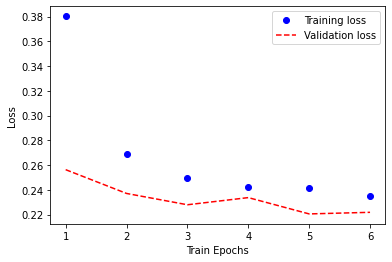

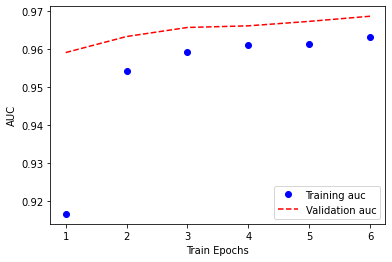

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["hla_linear_loss"]
val_loss = history_dict["val_hla_linear_loss"]
auc = history_dict["hla_linear_auc"]
val_auc = history_dict["val_hla_linear_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [9]:
n = 5
s = 100

#p = model.model(x_val[:1000,:])[0][:]
p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

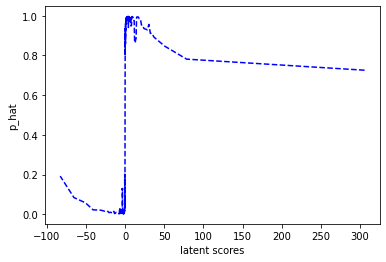

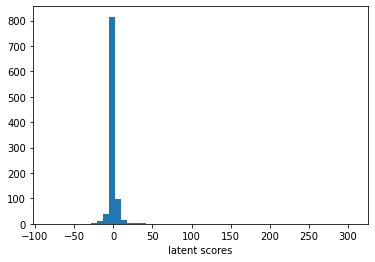

In [10]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

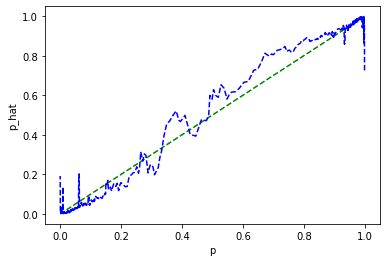

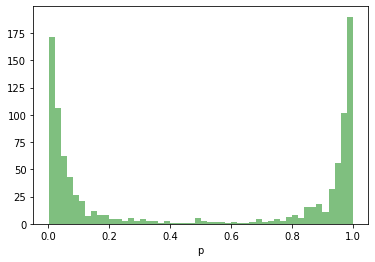

In [11]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

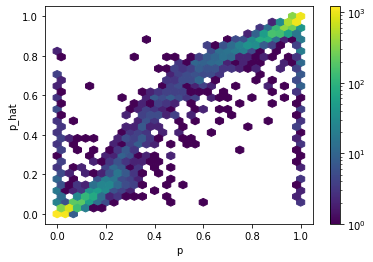

In [12]:
n = 1
s = 100

#p = model.model(x_val[:10000,:])[0][:].numpy()[:,0]
p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

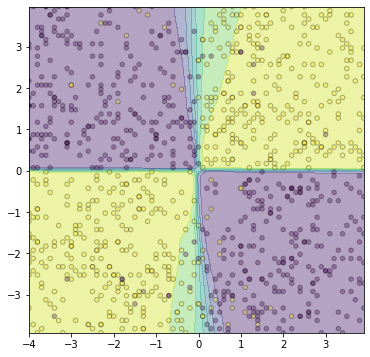

In [19]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z[:,0].reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [20]:
model.summary()

Model: "HLADropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense_72 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_73 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_74 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0

In [21]:
champion_params

{'learning_rate': 0.007,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.2213808298110962, 'epoch': 6},
 'best_auc': {'auc': 0.9677990078926086, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.9227499961853027, 'epoch': 6}}

In [13]:
## mcdropout 
##champion_params
{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.21947233378887177, 'epoch': 6},
 'best_auc': {'auc': 0.9679520130157471, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.9244999885559082, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7f3da9502970>}

{'learning_rate': 0.005600000000000001,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.21947233378887177, 'epoch': 6},
 'best_auc': {'auc': 0.9679520130157471, 'epoch': 6},
 'best_accuracy': {'accuracy': 0.9244999885559082, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7f3da9502970>}

In [22]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2992284297943115, 'epoch': 119},
  'best_auc': {'auc': 0.9505606293678284, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9125999808311462, 'epoch': 119}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2824668884277344, 'epoch': 119},
  'best_auc': {'auc': 0.9531910419464111, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9177500009536743, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.2683708965778351, 'epoch': 119},
  'best_auc': {'auc': 0.9568484425544739, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9197999835014343, 'epoch': 113}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.26549410820007324, 'epoch': 249},
  'best_auc': {'auc': 0.9579653739929199, 'epoch': 249},
  'b

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25